<a href="https://colab.research.google.com/github/Karthikeyan-ganesan86/Mscproj/blob/main/05_DISSERT_Back_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BACKTESTING

## Backtesting the stocks Google and Microsoft to see how they are behaving
## Implementation of Drawdowns
## Trend strategy in Backtesting


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
start_date = "2023-01-01"
end_date = "2023-02-11"
df = yf.download(['GOOG', 'MSFT'], start=start_date, end=end_date)

[*********************100%%**********************]  2 of 2 completed


In [ ]:
df2 = df['Adj Close']

<Axes: xlabel='Date'>

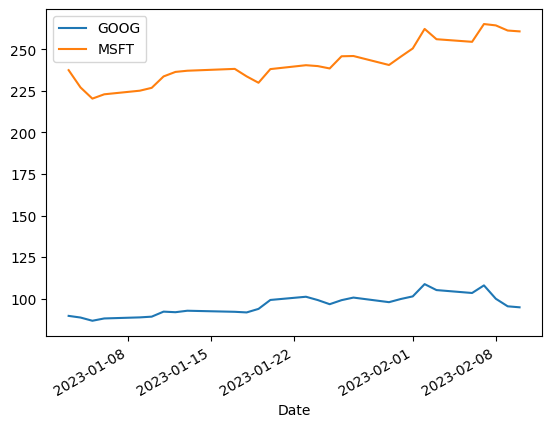

In [ ]:
df2.plot.line()

In [ ]:
returns_df = df2.pct_change()

In [ ]:
returns_df.head()

,GOOG,MSFT
Date,,
2023-01-03,NaN,NaN
2023-01-04,-0.011037,-0.043743
2023-01-05,-0.021869,-0.029638
2023-01-06,0.016019,0.011785
2023-01-09,0.007260,0.009736


<Axes: xlabel='Date'>

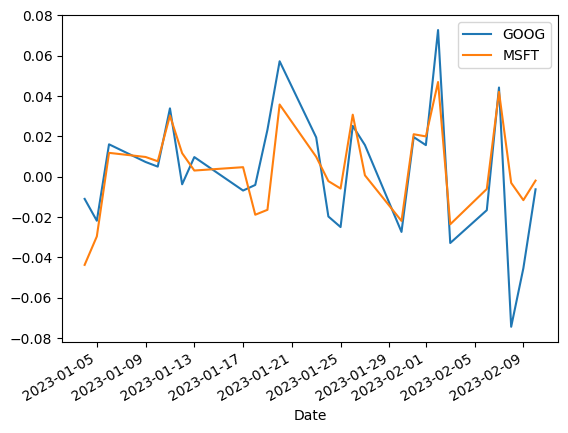

In [ ]:
returns_df.plot.line()

In [ ]:
initial_wealth = 1000


wealth_index_df = initial_wealth*(1+returns_df).cumprod()

In [ ]:
wealth_index_df.loc["2023-01-03"] = initial_wealth

<Axes: xlabel='Date'>

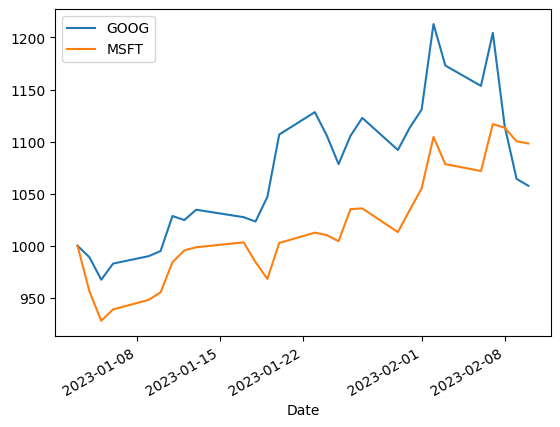

In [ ]:
wealth_index_df.plot.line()

In [ ]:
prior_peaks_df = wealth_index_df.cummax()

In [ ]:
drawdown_df = (wealth_index_df - prior_peaks_df) / prior_peaks_df

<Axes: xlabel='Date'>

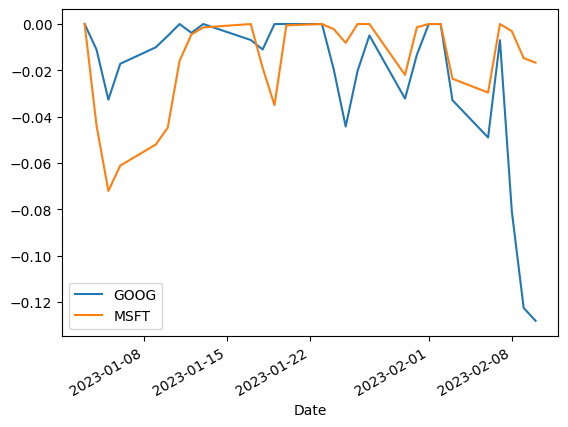

In [ ]:
drawdown_df.plot.line()

In [ ]:
drawdown_df.min()

GOOG   -0.128125
MSFT   -0.072084
dtype: float64

## DRAWDOWN USING FUNCTION

In [ ]:
def drawdown(return_series: pd.Series):
    """
    Input: a time series of asset returns
    Output: a DataFrame that contains:
    - the wealth index
    - the prior peaks
    - percentage drawdowns
    """
    wealth_index_series = initial_wealth*(1+return_series).cumprod()
    prior_peaks_series = wealth_index_series.cummax()
    drawdown_series = (wealth_index_series - prior_peaks_series) / prior_peaks_series
    return pd.DataFrame({
        "Wealth index": wealth_index_series,
        "Prior peaks": prior_peaks_series,
        "Drawdown": drawdown_series
    })

In [ ]:
drawdown(returns_df["GOOG"]).head()

,Wealth index,Prior peaks,Drawdown
Date,,,
2023-01-03,NaN,NaN,NaN
2023-01-04,988.963234,988.963234,0.000000
2023-01-05,967.335558,988.963234,-0.021869
2023-01-06,982.831735,988.963234,-0.006200
2023-01-09,989.966623,989.966623,0.000000


<Axes: xlabel='Date'>

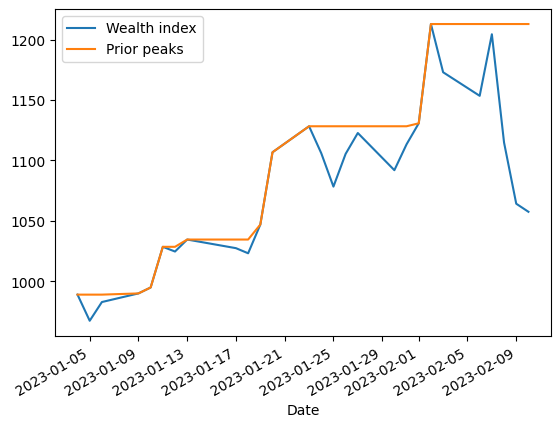

In [ ]:
drawdown(returns_df["GOOG"])[['Wealth index', 'Prior peaks']].plot.line()

<Axes: xlabel='Date'>

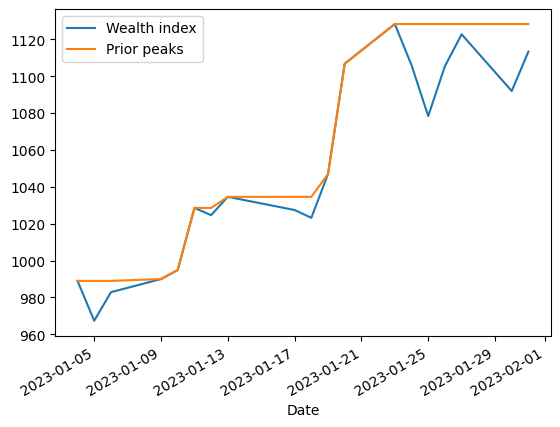

In [ ]:
drawdown(returns_df.loc["2023-01","GOOG"])[['Wealth index', 'Prior peaks']].plot.line()


## BACKTESTING TREND STRATEGY

In [ ]:
df_goog = yf.download(['GOOG'], start="2022-01-01", end="2023-01-01")['Adj Close']


df_goog = pd.DataFrame(df_goog)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
sma_span = 30
ema_span = 5
short_ma = 'ema'+str(ema_span)
long_ma ='sma'+str(sma_span)
df_goog[long_ma] = df_goog['Adj Close'].rolling(sma_span).mean()
df_goog[short_ma] = df_goog['Adj Close'].ewm(span=ema_span).mean()
df_goog.head()

,Adj Close,sma30,ema5
Date,,,
2022-01-03,145.074493,NaN,145.074493
2022-01-04,144.416504,NaN,144.679700
2022-01-05,137.653503,NaN,141.351501
2022-01-06,137.550995,NaN,139.772829
2022-01-07,137.004501,NaN,138.710106


In [ ]:
df_goog.dropna(inplace=True)
df_goog.head()


,Adj Close,sma30,ema5
Date,,,
2022-02-14,135.300003,137.335750,137.064586
2022-02-15,136.425507,137.047450,136.851559
2022-02-16,137.487503,136.816483,137.063541
2022-02-17,132.308502,136.638317,135.478525
2022-02-18,130.467499,136.402200,133.808181


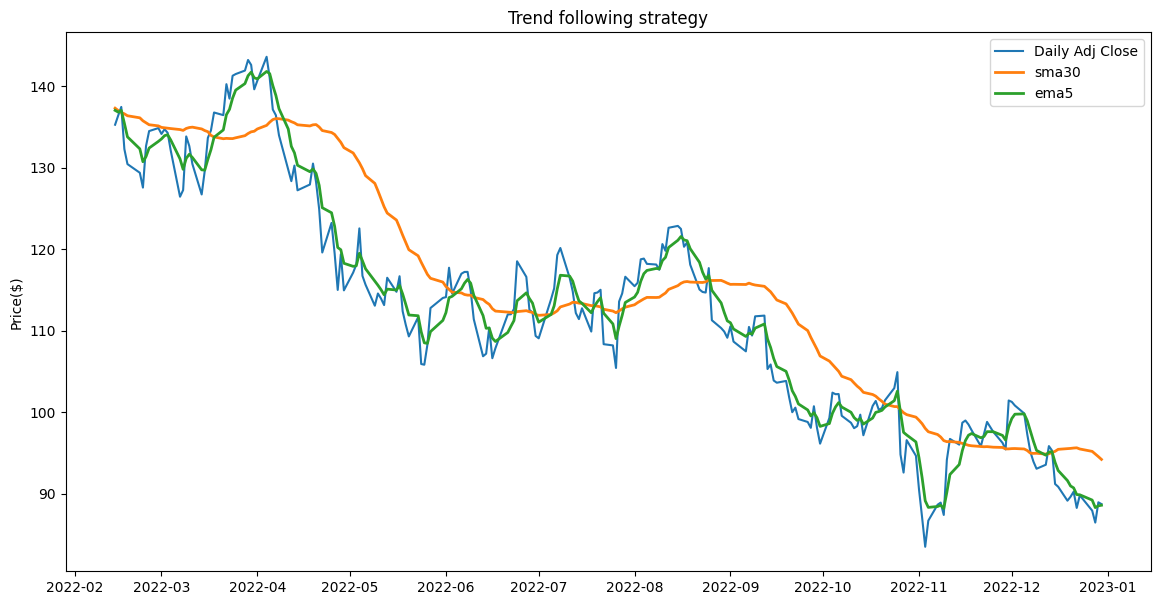

In [ ]:

fig = plt.figure(figsize=(14,7))


plt.plot(df_goog.index, df_goog['Adj Close'], linewidth=1.5, label='Daily Adj Close')


plt.plot(df_goog.index, df_goog[long_ma], linewidth=2, label=long_ma)


plt.plot(df_goog.index, df_goog[short_ma], linewidth=2, label=short_ma)


plt.title("Trend following strategy")


plt.ylabel('Price($)')


plt.legend()


In [ ]:
df_goog['log_return_buy_n_hold'] = np.log(df_goog['Adj Close']).diff()

In [ ]:
# identify buy signal
df_goog['signal'] = np.where(df_goog[short_ma] > df_goog[long_ma], 1, 0)
# identify sell signal
df_goog['signal'] = np.where(df_goog[short_ma] < df_goog[long_ma], -1, df_goog['signal'])
df_goog.dropna(inplace=True)
df_goog.head()

,Adj Close,sma30,ema5,log_return_buy_n_hold,signal
Date,,,,,
2022-02-15,136.425507,137.047450,136.851559,0.008284,-1
2022-02-16,137.487503,136.816483,137.063541,0.007754,1
2022-02-17,132.308502,136.638317,135.478525,-0.038397,-1
2022-02-18,130.467499,136.402200,133.808181,-0.014012,-1
2022-02-22,129.402496,136.148800,132.339619,-0.008196,-1


In [ ]:
df_goog['log_return_trend_follow'] = df_goog['signal'] * df_goog['log_return_buy_n_hold']

In [ ]:
# terminal return of buy-n-hold


np.exp(df_goog['log_return_buy_n_hold']).cumprod()[-1] -1

-0.34419806832531485

In [ ]:
# terminal return of trend following


np.exp(df_goog['log_return_trend_follow']).cumprod()[-1] -1

0.3609149965748295

In [ ]:
# calculate annualized return of buy-n-hold


annualized_return_buy_n_hold = np.exp(df_goog['log_return_buy_n_hold']).prod()**(252/df_goog.shape[0])-1


annualized_return_buy_n_hold

-0.3818823804560595

In [ ]:
# calculate annualized return of trend following


annualized_return_trend_follow = np.exp(df_goog['log_return_trend_follow']).prod()**(252/df_goog.shape[0])-1
annualized_return_trend_follow

0.42103139838297543

In [ ]:
np.exp(df_goog['log_return_trend_follow'].sum())**(252/df_goog.shape[0])-1

0.42103139838297277

In [ ]:
# calculate annualized volatility of buy-n-hold


annualized_vol_buy_n_hold = (np.exp(df_goog['log_return_buy_n_hold'])-1).std()*(252**0.5)


annualized_vol_buy_n_hold

0.38968362248999705

In [ ]:
# calculate annualized volatility of trend following


annualized_vol_trend_follow = (np.exp(df_goog['log_return_trend_follow'])-1).std()*(252**0.5)

annualized_vol_trend_follow

0.3928554640873459

In [ ]:
riskfree_rate = 0.03


# calculate Sharpe ratio of buy-n-hold


sharpe_ratio_buy_n_hold = (annualized_return_buy_n_hold - riskfree_rate) / annualized_vol_buy_n_hold


sharpe_ratio_buy_n_hold



-1.0569661045137515

In [ ]:
# calculate Sharpe ratio of trend following


sharpe_ratio_trend_follow = (annualized_return_trend_follow - riskfree_rate) / annualized_vol_trend_follow

sharpe_ratio_trend_follow

0.9953569038205742

In [ ]:
# max drawdown of buy-n-hold
max_drawdown_buy_n_hold = drawdown(np.exp(df_goog['log_return_buy_n_hold'])-1)['Drawdown'].min()
max_drawdown_buy_n_hold

-0.41876535983781227

In [ ]:
# max drawdown of trend following
max_drawdown_trend_follow = drawdown(np.exp(df_goog['log_return_trend_follow'])-1)['Drawdown'].min()
max_drawdown_trend_follow


-0.20685357874978333